In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import io
from google.colab import files
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


##Load any data here

In [2]:
infertility = pd.read_csv('gdrive/MyDrive/NLP_final_project/infertility_processed_posts.txt')
afterloss = pd.read_csv('gdrive/MyDrive/NLP_final_project/ttcafterloss_processed_posts.txt')

In [ ]:
infertility.head()

,Unnamed: 0,id,created_utc,author,author_fullname,author_flair_text,url,title,selftext,upvote_ratio,score,num_comments,data_split,processed_text,processed_title
0,0,2t72mf,1.421865e+09,nhmejia,t2_ivw2a,Hard to get pregnant after a hysto.,https://www.reddit.com/r/infertility/comments/...,*TRIGGER WARNING* Not that funny...,I've been doing really well staying away from ...,0.80,8,25,val,"[['I', 'be', 'do', 'really', 'well', 'stay', '...","[['trigger', 'warn', 'not', 'that', 'funny']]"
1,1,2t6u8l,1.421862e+09,septicidal,t2_6h9ib,PCOS,https://www.reddit.com/r/infertility/comments/...,Update on planning for a new cycle,I know a bunch of people saw my update in the ...,1.00,7,8,train,"[['I', 'know', 'a', 'bunch', 'of', 'people', '...","[['update', 'on', 'plan', 'for', 'a', 'new', '..."
2,3,2t57np,1.421820e+09,PoisonRose23,t2_j2zbu,NaN,https://www.reddit.com/r/infertility/comments/...,Decision about fermara! I need advice!!!,Long post warning: So I have a decision to mak...,1.00,1,6,train,"[['long', 'post', 'warn', 'so', 'I', 'have', '...","[['decision', 'about', 'fermara', 'I', 'need',..."
3,5,2t45rt,1.421801e+09,Pamzella,t2_aifrd,41 MFI & DOR 1MC mult IUIs,https://www.reddit.com/r/infertility/comments/...,"""Shared risk"" clinics","Please educate me, someone asked me about this...",1.00,7,17,train,"[['please', 'educate', 'I', 'someone', 'ask', ...","[['share', 'risk', 'clinic']]"
4,6,2t3x6r,1.421797e+09,fumbellina,t2_iibv6,NaN,https://www.reddit.com/r/infertility/comments/...,FET anxiety,"My FET is scheduled for next week, and I'm fee...",0.81,3,6,train,"[['my', 'fet', 'be', 'schedule', 'for', 'next'...","[['fet', 'anxiety']]"


## Any data preprocessing (input and outputs)

In [3]:
#get training and validation sets

infertility_train = infertility[infertility.data_split == 'train']
infertility_val = infertility[infertility.data_split == 'test']

afterloss_train = afterloss[afterloss.data_split == 'train']
afterloss_val = afterloss[afterloss.data_split == 'test']

In [98]:
# #combine infertility and train!
print(infertility_val.shape)
afterloss_val.shape
# infertility_afterloss_train = pd.concat([infertility[infertility.data_split == 'train'], afterloss[afterloss.data_split == 'train'] ])
# infertility_afterloss_val = pd.concat([infertility[infertility.data_split == 'val'],afterloss[afterloss.data_split == 'val'] ])

(2978, 15)


(1483, 15)

In [4]:


def rebuild_sentences(df_text_values, df_title_values):
  all_sentences = []
  for p in range(len(df_text_values)):
    post = df_text_values[p][0][2:len(df_text_values[p][0]) - 2]
    post_no_token = post.replace("', '", " ")
    post_sentences = post_no_token.split("], [")
    post_sentences = [sent.replace("'", "") for sent in post_sentences]
    all_sentences += post_sentences

    title = df_title_values[p][0][2:len(df_title_values[p][0]) - 2]
    no_token = title.replace("', '", " ")
    newtitle = no_token.replace("'", "")
    all_sentences.append(newtitle)

  return all_sentences

#rebuild corpus of infertility train sentences
i_train_texts = infertility_train[['processed_text']].values
i_train_titles = infertility_train[['processed_title']].values
i_train_fulllist = rebuild_sentences(i_train_texts, i_train_titles)

print('Total number of sentences in train infertility: ' + str(len(i_train_fulllist)))

#rebuild corpus of ttcafterloss train sentences
t_train_texts = afterloss_train[['processed_text']].values
t_train_titles = afterloss_train[['processed_title']].values
t_train_fulllist = rebuild_sentences(t_train_texts, t_train_titles)

print('Total number of sentences in train ttc: ' + str(len(t_train_fulllist)))

#rebuild corpus of infertility train sentences
i_val_texts = infertility_val[['processed_text']].values
i_val_titles = infertility_val[['processed_title']].values
i_val_fulllist = rebuild_sentences(i_val_texts, i_val_titles)

print('Total number of sentences in val infertility: ' + str(len(i_val_fulllist)))

#rebuild corpus of ttcafterloss train sentences
t_val_texts = afterloss_val[['processed_text']].values
t_val_titles = afterloss_val[['processed_title']].values
t_val_fulllist = rebuild_sentences(t_val_texts, t_val_titles)

print('Total number of sentences in val ttc: ' + str(len(t_val_fulllist)))


Total number of sentences in train infertility: 111523
Total number of sentences in train ttc: 61197
Total number of sentences in val infertility: 37127
Total number of sentences in val ttc: 20570


Initial vectorizer

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

i_vectorizer = CountVectorizer(max_features=10000)
i_vectorizer.fit(i_train_fulllist)

t_vectorizer = CountVectorizer(max_features=10000)
t_vectorizer.fit(t_train_fulllist)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [6]:
#tokenize sequences

from tensorflow.keras.preprocessing.text import Tokenizer

#create keras tokenizer
max_words = 10000
i_tokenizer = Tokenizer(max_words, oov_token='OOV')
i_tokenizer.fit_on_texts(i_train_fulllist)
i_vocab_size = max_words + 1

t_tokenizer = Tokenizer(max_words, oov_token='OOV')
t_tokenizer.fit_on_texts(t_train_fulllist)
t_vocab_size = max_words + 1


#convert text to sequences
i_tokenized_train = i_tokenizer.texts_to_sequences(i_train_fulllist)
i_tokenized_val = i_tokenizer.texts_to_sequences(i_val_fulllist)

t_tokenized_train = t_tokenizer.texts_to_sequences(t_train_fulllist)
t_tokenized_val = t_tokenizer.texts_to_sequences(t_val_fulllist)

##Build Word2Vec representations

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Word2VecModel(nn.ModuleList):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.

    def __init__(self, vocab_size, embed_dim):
      super(Word2VecModel, self).__init__()

        #word2vec: 2 linear layers, 1 softmax
      
      self.lin1 = nn.Linear(embed_dim, vocab_size+1) #layer calculates embedded representations
        
      self.softmax = nn.Softmax().to(device)
      self.embed =  nn.Embedding(vocab_size+1, embed_dim, padding_idx=0)  #get embedded representations from embedding dict


    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids
        # this function should return a set of scores for predicting the word 
        # in the middle of the context

        context = context.to(device)

        # Your code here!  torch.LongTensor(context)
        out_embed = self.embed(context).to(device=device)  #convert indices to sparse layer lookup table
        avg_embed = torch.mean(out_embed, dim = 1).to(device=device)
        out_linear = self.lin1(avg_embed).to(device=device)
        out = self.softmax(out_linear).to(device=device)

        return out

    def getEmbedWeights(self): #get matrix of embedded word representations
      
      return self.embed.weight.to(device=device) 


Ngrams

In [ ]:
def get_ngrams(tokenized_corpus, window_size):
    # review = train_labels_b
    ngrams = []
    for i, review in enumerate(tokenized_corpus):
        # print(review)
        for j, word in enumerate(review):
            min_ind = max(0, j-window_size)
            max_ind = min(len(review), j+window_size+1)
            ctx = np.zeros(2 * window_size, dtype=np.int64) - 1
            for ik, k in enumerate(range(min_ind, j)):
                ctx[ik] = review[k]
            for ik, k in enumerate(range(j+1, max_ind)):
                ctx[window_size+ik] = review[k]
            ngrams.append((ctx, review[j]))
    return ngrams

In [ ]:

def learn_reps_word2vec(tokenized_input, window_size, rep_size, n_epochs, n_batch):
    #This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of 
    # the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    #apply 6.864 ngrams
    ngrams_input = get_ngrams(tokenized_input, 2)

    #apply my ngrams
    # ngrams_input = [ngrams(post) for post in tokenized_input ]

    # device = torch.device('cuda')  # run on colab gpu
    # device = 'cuda'
    
    model = Word2VecModel(10000, rep_size).to(device=device)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    # next(model.parameters()).device

    loader = torch_data.DataLoader(ngrams_input, batch_size=n_batch, shuffle=True)

    # print(ngrams_input.shape)
    # print(ngrams_input)

    # Use cross-entropy loss function for Word2Vec!
    loss_fn = torch.nn.CrossEntropyLoss() #combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

    losses = []  # Potentially useful for debugging (loss should go down!)
    
    from tqdm import tqdm

    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.


            # Here, perform a forward pass to compute predictions for the model.
            
            context = context + 1
          
            preds = model.forward(context).to(device)  # Your code here!

            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradients
            # of the model parameters, perform the backward pass, and
            # update the model parameters.

            #compute loss
            loss = loss_fn(preds, label.to(device))  # Your code here!
            #zero gradients
            opt.zero_grad()
            #perform backward pass
            loss.backward()  
            #update parameters
            opt.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = model.getEmbedWeights()  # Your code here!

    return embedding_matrix
    

Make embeddings! and save em

In [ ]:
# Use the function you just wrote to learn Word2Vec embeddings on a word-level:
i_reps_word2vec = learn_reps_word2vec(i_tokenized_train,  #reduce size to stop RAM from crashing
                                    2,   #window size
                                    100, #embedding size, was initially 500 but thing timed out 
                                    10, 
                                    5)

torch.save(i_reps_word2vec, 'gdrive/MyDrive/NLP_final_project/i_W2V_embed_weights_100dim_2window.pt') 

print('finished i')

t_reps_word2vec = learn_reps_word2vec(t_tokenized_train,  #reduce size to stop RAM from crashing
                                    2,   #window size
                                    100, #embedding size, was initially 500 but thing timed out 
                                    10, 
                                    5)

torch.save(t_reps_word2vec, 'gdrive/MyDrive/NLP_final_project/t_W2V_embed_weights_100dim_2window.pt') 

print('finished t')

# it_reps_word2vec = learn_reps_word2vec(it_tokenized_train,  #reduce size to stop RAM from crashing
#                                     2,   #window size
#                                     100, #embedding size, was initially 500 but thing timed out 
#                                     10, 
#                                     5)

# torch.save(it_reps_word2vec, 'gdrive/MyDrive/NLP_final_project/it_W2V_embed_weights_100dim_2window.pt') 

# print('finished it')




  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

In [8]:
import torch 

#load later on
i_reps_word2vec = torch.load('gdrive/MyDrive/NLP_final_project/i_W2V_embed_weights_100dim_2window.pt', map_location=torch.device('cpu'))[1:]
print(i_reps_word2vec.shape)
t_reps_word2vec = torch.load('gdrive/MyDrive/NLP_final_project/t_W2V_embed_weights_100dim_2window.pt', map_location=torch.device('cpu'))[1:]
print(t_reps_word2vec.shape)
# it_reps_word2vec = torch.load('gdrive/MyDrive/NLP_final_project/it_W2V_embed_weights_100dim_2window.pt', map_location=torch.device('cpu'))[1:]
# print(it_reps_word2vec.shape)

torch.Size([10000, 100])
torch.Size([10000, 100])


In [ ]:
# # i_train = i_vectorizer.transform(i_train_fulllist) 
# print(i_train.shape, i_reps_word2vec.shape)
# print(type(i_train), type(i_reps_word2vec))
# new = reps_word2vec.detach().numpy()

# x = i_train[0].toarray().T * new

(111523, 10000) torch.Size([10000, 100])
<class 'scipy.sparse.csr.csr_matrix'> <class 'torch.Tensor'>


Get sentence-level embeddings, NOT post-level embeddings. Need to figure out how to do post-level still

111523

In [10]:

def w2v_featurizer(xs,reps_word2vec):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).

    feats = np.zeros((xs.shape[0], reps_word2vec.shape[1]))  
    reps_word2vec = reps_word2vec.detach().numpy()



    for j in range(xs.shape[0]):
      # print(xs[j].shape)
      # print(reps_word2vec[:10000,].shape)



      post = xs[j].toarray()

      # print(np.sum(post))

      x = (reps_word2vec.T * post).T
      
      # print(x)
      # print(x.shape)  

      denom = 1  
      if np.sum(post) != 0 : denom = np.sum(post)


      feats[j] = np.sum(x, axis=0) / denom

      

      # print(feats[j].shape)
      # print(s)
      
      # print(newrow)
      # newrow = xs[j,0] * reps_word2vec[0] #shape is (1, 500)
      # for i in range(1, xs.shape[1]):
      #   newrow += xs[j,i] * reps_word2vec[i]   



      # feats[j] = (s / np.sum(xs[:,j]))
      if np.isnan(denom)==True: 
        print('denom is nan')
        print(np.sum(post))
      # if np.isnan(feats[j]).any()==True: print('feats[j] 0')  

    # feats = np.dot(xs, reps_word2vec) / np.sum(xs, axis=1, keepdims=True)


    #average all the word embeddings in review to create overall embedding

    # normalize
    normalize_term = np.sqrt((feats ** 2).sum(axis=1, keepdims=True))
    normalize_term[normalize_term == 0] = 1  
    # print(normalize_term)
    
    # print(normalize_term)
    # print()
    # print(feats.shape)


    return feats / normalize_term

#convert to term-document matrix
i_train = i_vectorizer.transform(i_train_fulllist) 
i_val = i_vectorizer.transform(i_val_fulllist) 

t_train = t_vectorizer.transform(t_train_fulllist)
t_val = t_vectorizer.transform(t_val_fulllist)

# i_train_w2v = w2v_featurizer(i_train, i_reps_word2vec)
i_val_w2v = w2v_featurizer(i_val, i_reps_word2vec)

# t_train_w2v = w2v_featurizer(t_train, t_reps_word2vec)
t_val_w2v = w2v_featurizer(t_val, t_reps_word2vec)

# print(f"Word2Vec features, {i_train.shape[0]} examples")
print(f"Word2Vec features, {i_val.shape[0]} examples")
print(f"Word2Vec features, {t_train.shape[0]} examples")
print(f"Word2Vec features, {t_val.shape[0]} examples")

Word2Vec features, 37127 examples
Word2Vec features, 61197 examples
Word2Vec features, 20570 examples


In [ ]:
# print(len(i_train_fulllist), len(i_val_fulllist))

print(np.isnan(i_reps_word2vec.detach().numpy()).any(),
np.isnan(t_reps_word2vec.detach().numpy()).any()
)

# print(np.isnan(i_train_w2v).any(),np.isnan(i_val_w2v).any())

# print(np.isnan(i_train).any(), np.isnan(i_val).any())

False False


In [ ]:
torch.save(i_train_w2v, 'gdrive/MyDrive/NLP_final_project/i_train_w2v.pt') 
torch.save(i_val_w2v, 'gdrive/MyDrive/NLP_final_project/i_val_w2v.pt') 
torch.save(t_train_w2v, 'gdrive/MyDrive/NLP_final_project/t_train_w2v.pt') 
torch.save(t_val_w2v, 'gdrive/MyDrive/NLP_final_project/t_val_w2v.pt') 

Generate post-level embeddings

In [9]:
import torch
i_train_w2v = torch.load('gdrive/MyDrive/NLP_final_project/i_train_w2v.pt', map_location=torch.device('cpu')) 
i_val_w2v = torch.load('gdrive/MyDrive/NLP_final_project/i_val_w2v.pt', map_location=torch.device('cpu')) 
t_train_w2v = torch.load('gdrive/MyDrive/NLP_final_project/t_train_w2v.pt', map_location=torch.device('cpu')) 
t_val_w2v = torch.load('gdrive/MyDrive/NLP_final_project/t_val_w2v.pt', map_location=torch.device('cpu')) 

In [ ]:
i_reps_word2vec[0:15]

tensor([[-1.1255, -0.7143, -0.5299,  ...,  0.3912, -0.6389,  0.2989],
        [ 1.0169,  0.9714, -0.4754,  ...,  0.0953,  0.0605,  1.3242],
        [-1.1939, -0.6632, -1.7322,  ...,  0.8786, -0.1547,  1.8871],
        ...,
        [ 0.6317, -1.7761, -0.6073,  ...,  0.5374,  0.5360, -0.4991],
        [-0.8232,  0.6666, -0.7481,  ...,  0.3377,  0.2431,  0.0411],
        [-1.8941,  0.0591, -1.9632,  ..., -0.1481,  1.4777, -1.2726]],
       grad_fn=<SliceBackward>)

In [ ]:

count=0
for i in i_train_w2v:
  # i = i.detach().cpu().numpy()
  if i.all() == 0: count+=1
print(count, i_train_w2v.shape)  

0 (111523, 100)


## Assign minimal threshold for post word count

In [ ]:
# test = "[['I', 'know', 'a', 'bunch', 'of', 'people', 'cycle'], ['my', ]]"

# num_words_per_post = [post[0].count(' ') for post in i_val_texts]

# # plt.hist(num_words_per_post)

# #look at thresholds
# count = [1 if i > 10 else 0 for i in num_words_per_post ]
# print(len(num_words_per_post))
# print(sum(count))


# print(i_train_w2v.shape)

2977
2878
(111523, 100)


In [14]:
threshold = 0

i_train_post_embeddings_0 = post_from_sentence_embeddings(i_train_texts, i_train_w2v,threshold)
i_val_post_embeddings_0 = post_from_sentence_embeddings(i_val_texts, i_val_w2v,threshold)

t_train_post_embeddings_0 = post_from_sentence_embeddings(t_train_texts, t_train_w2v,threshold)
t_val_post_embeddings_0 = post_from_sentence_embeddings(t_val_texts, t_val_w2v,threshold)

#get corresponding UP VOTE RATIO outcome values

num_words_per_post = np.array([post[0].count(' ') for post in i_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_train_upvote_ratio_0 = np.take(i_train_upvote_ratio, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in i_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_val_upvote_ratio_0 = np.take(i_val_upvote_ratio, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_train_upvote_ratio_0 = np.take(t_train_upvote_ratio, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_val_upvote_ratio_0 = np.take(t_val_upvote_ratio, filter_indices,0)

#get corresponding NUM COMMENTS outcome values

num_words_per_post = np.array([post[0].count(' ') for post in i_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_train_num_comments_0 = np.take(i_train_num_comments, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in i_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_val_num_comments_0 = np.take(i_val_num_comments, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_train_num_comments_0 = np.take(t_train_num_comments, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_val_num_comments_0 = np.take(t_val_num_comments, filter_indices,0)

8932
8932
2978
2978
4444
4444
1483
1483


In [13]:
##post embeddings

def post_from_sentence_embeddings(_texts, _w2v, min_words):
  #get number of sentences per post
  num_sent_per_post = [post[0].count('], [') + 1 for post in _texts]

  #initialize return value and from index
  fr_index=0

  #get number of posts above threshold
  num_words_per_post = [post[0].count(' ') for post in _texts]
  print(len(num_words_per_post))
  above_thresh = [1 if i > min_words else 0 for i in num_words_per_post ]
  print(len(above_thresh))
  post_embeddings= np.zeros((sum(above_thresh), 100))



  #SUM the corresponding number of sentence embeddings together to get post embeddings 
  index=0
  for i in range(len(num_sent_per_post)):
      to_index = fr_index + num_sent_per_post[i]
      targ_sentences = _w2v[fr_index:to_index, :]
      targ_post = np.sum(targ_sentences, axis=0)
      targ_post = targ_post + _w2v[to_index, :] #dont forget title embedding in post embedding
      targ_post = targ_post / (num_sent_per_post[i] + 1) #get average
      fr_index = to_index + 1
      if above_thresh[i] == 1:
        post_embeddings[index] = targ_post
        index+=1
  return post_embeddings

  # post_from_sentence_embeddings(i_train_texts, i_train_w2v)

Use these post embeddings for outcome prediction!


In [ ]:
# threshold =  10
# i_train_post_embeddings_10 = post_from_sentence_embeddings(i_train_texts, i_train_w2v, threshold)
# i_val_post_embeddings_10 = post_from_sentence_embeddings(i_val_texts, i_val_w2v, threshold)

# t_train_post_embeddings_10 = post_from_sentence_embeddings(t_train_texts, t_train_w2v, threshold)
# t_val_post_embeddings_10 = post_from_sentence_embeddings(t_val_texts, t_val_w2v, threshold)


# print(i_train_post_embeddings_10.shape)
# print(i_val_post_embeddings_10.shape)
# print(t_train_post_embeddings_10.shape)


# #get filtered post outcomes only
# num_words_per_post = np.array([post[0].count(' ') for post in i_train_texts])
# filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
# i_train_upvote_ratio_2_10 = np.take(i_train_upvote_ratio_2, filter_indices,0)

# num_words_per_post = np.array([post[0].count(' ') for post in i_val_texts])
# filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
# i_val_upvote_ratio_2_10 = np.take(i_val_upvote_ratio_2, filter_indices,0)

# num_words_per_post = np.array([post[0].count(' ') for post in t_train_texts])
# filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
# t_train_upvote_ratio_2_10 = np.take(t_train_upvote_ratio_2, filter_indices,0)

# num_words_per_post = np.array([post[0].count(' ') for post in t_val_texts])
# filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
# t_val_upvote_ratio_2_10 = np.take(t_val_upvote_ratio_2, filter_indices,0)

Word embeddings

In [ ]:
def show_similar_words(vectorizer, tokenizer, reps, tokens):
    reps = reps.detach().numpy()
    reps = reps / (np.sqrt((reps ** 2).sum(axis=1, keepdims=True)))
    #for i, (word, token) in enumerate(tokenizer.word_to_token.items()):
    for token in tokens:
        word = vectorizer.get_feature_names()[token]
        rep = reps[token, :]
        sims = ((reps - rep) ** 2).sum(axis=1)
        nearest = np.argsort(sims)
        print(word, token)
        for j in nearest[1:10]:
            print(" ", vectorizer.get_feature_names()[j], "%.3f" % sims[j])

reps = i_reps_word2vec
words = ["period","clinic", "life"]
show_tokens = [i_vectorizer.get_feature_names().index(word) for word in words]
show_similar_words(i_vectorizer, i_tokenizer, reps, show_tokens)

period 6426
  pende 1.097
  appease 1.124
  bummed 1.138
  distancing 1.147
  fertilityiq 1.156
  profession 1.166
  children 1.166
  cheesy 1.167
  grr 1.170
clinic 1502
  buy 1.116
  fertilise 1.144
  green 1.159
  advanced 1.186
  fertilisation 1.209
  cohort 1.218
  cruel 1.245
  anchor 1.267
  pace 1.269
life 4974
  episona 1.235
  shenanigan 1.337
  intervention 1.349
  typical 1.351
  cord 1.354
  quantitative 1.356
  attack 1.372
  ma 1.375
  anecdote 1.377


In [ ]:
reps = t_reps_word2vec
words = ["doctor","medical", "clinic"]
show_tokens = [t_vectorizer.get_feature_names().index(word) for word in words]
show_similar_words(t_vectorizer, t_tokenizer, reps, show_tokens)

doctor 2763
  frick 1.051
  advocate 1.071
  because 1.122
  breath 1.122
  ect 1.152
  cvs 1.159
  entitle 1.166
  away 1.177
  cw 1.183
medical 5339
  wing 1.295
  terrified 1.303
  bio 1.344
  insert 1.367
  dhea 1.374
  annoying 1.382
  gila 1.398
  south 1.400
  dependent 1.401
clinic 1627
  incident 1.176
  across 1.205
  blindside 1.216
  ace 1.222
  act 1.241
  firsthand 1.245
  an 1.274
  arm 1.290
  corner 1.295


##Do clustering on Word2vec embeddings

In [ ]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec.detach().numpy())
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1])
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")

## Outcome prediction

In [11]:
i_train_num_comments = infertility_train.num_comments
i_val_num_comments = infertility_val.num_comments
t_train_num_comments = afterloss_train.num_comments
t_val_num_comments = afterloss_val.num_comments

i_train_upvote_ratio = infertility_train.upvote_ratio
i_val_upvote_ratio = infertility_val.upvote_ratio
t_train_upvote_ratio = afterloss_train.upvote_ratio
t_val_upvote_ratio = afterloss_val.upvote_ratio

4655 4277
1563 1414


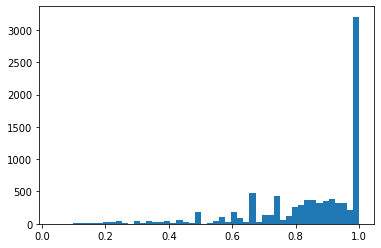

In [ ]:
import matplotlib.pyplot as plt

#make binary comments
plt.hist(i_train_upvote_ratio, bins=50)

#predict either
x = list(i_train_upvote_ratio.values)
i_train_upvote_ratio_2 = [1 if i >= 0.90 else 0 for i in x]
print(i_train_upvote_ratio_2.count(1), i_train_upvote_ratio_2.count(0))

y = list(i_val_upvote_ratio.values)
i_val_upvote_ratio_2 = [1 if i >= 0.90 else 0 for i in y]
print(i_val_upvote_ratio_2.count(1), i_val_upvote_ratio_2.count(0))

2694 1750
904 577


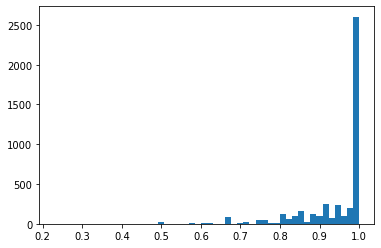

In [ ]:
import matplotlib.pyplot as plt

#make binary comments
plt.hist(t_train_upvote_ratio, bins=50)

#predict either
x = list(t_train_upvote_ratio.values)
t_train_upvote_ratio_2 = [1 if i >= 0.975 else 0 for i in x]
print(t_train_upvote_ratio_2.count(1), t_train_upvote_ratio_2.count(0))

y = list(t_val_upvote_ratio.values)
t_val_upvote_ratio_2 = [1 if i >= 0.975 else 0 for i in y]
print(t_val_upvote_ratio_2.count(1), t_val_upvote_ratio_2.count(0))

5707 3225
1908 1069


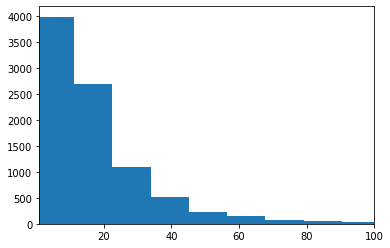

In [ ]:
import matplotlib.pyplot as plt

#make binary comments
plt.hist(i_train_num_comments, bins=50)
plt.xlim(1,100)
list(i_train_num_comments.values).count(10)

#predict either ≤10 or >10 comments
x = list(i_train_num_comments.values)
i_train_comments_2 = [1 if i >= 10 else 0 for i in x]
print(i_train_comments_2.count(1), i_train_comments_2.count(0))

y = list(i_val_num_comments.values)
i_val_comments_2 = [1 if i >= 10 else 0 for i in y]
print(i_val_comments_2.count(1), i_val_comments_2.count(0))

2400 2044
812 669


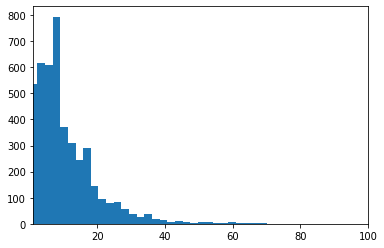

In [ ]:
import matplotlib.pyplot as plt

#make binary comments
plt.hist(t_train_num_comments, bins=50)
plt.xlim(1,100)
list(t_train_num_comments.values).count(10)

#predict either 8 or >8 comments
x = list(t_train_num_comments.values)
t_train_comments_2 = [1 if i >= 8 else 0 for i in x]
print(t_train_comments_2.count(1), t_train_comments_2.count(0))

y = list(t_val_num_comments.values)
t_val_comments_2 = [1 if i >= 8 else 0 for i in y]
print(t_val_comments_2.count(1), t_val_comments_2.count(0))

In [12]:
#import stuff

import pandas
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.preprocessing import LabelBinarizer


###Classifier for num_comments. W2V


###For infertility

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_features = i_train_post_embeddings_0.shape[1]

epochs=25

#initialize regression model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (linear function)
model.add(Dense(units=1, activation='linear', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(lr=0.0001)
# opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              loss='mean_squared_error', #use mean squared error
              metrics=['mse']) 

model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=i_train_post_embeddings_0, 
         y = i_train_upvote_ratio_0,
         batch_size=32,
         validation_data = (i_val_post_embeddings_0, i_val_upvote_ratio_0),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


Duplicate cell below for evaluation

In [ ]:
np.round(preds,2)

array([0.74, 0.85, 0.81, ..., 0.84, 0.82, 0.84], dtype=float32)

In [ ]:
from sklearn.metrics import r2_score
from scipy import stats

x=i_val_upvote_ratio_0.values

preds = model.predict(i_val_post_embeddings_0)
preds = preds.flatten()
preds = np.round(preds,2) #comment out for upvote ratio

print('R squared: '+str(r2_score(x, preds)))
print()
pr = stats.pearsonr(x, preds)
print('Pearson correlation: '+str(pr))
print()

print('Baseline check')

correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print('model:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print('mean:')
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print('median:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print('mode:')
print(sum([1 if i != -1 else 0 for i in correct]))
print()
print('total:')
print(len(preds))


R squared: 0.01503315551384421

Pearson correlation: (0.14401906425959488, 4.705047368339176e-15)

Baseline check
model:
1
mean:
1001
median:
1001
mode:
1001

total:
2931


Final MSE of training data set: 0.03329571709036827
Final MSE of validation data set: 0.033565010875463486



Text(0.5, 0, 'Epochs')

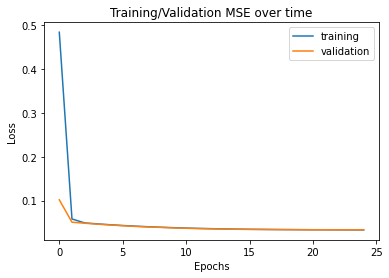

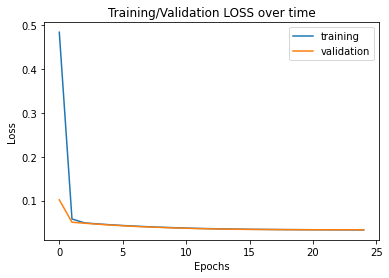

In [ ]:
#plot out mse
print('Final MSE of training data set: ' + str(np.mean(hist.history['mse'][-1])))
print('Final MSE of validation data set: ' + str(np.mean(hist.history['val_mse'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['mse'], label = 'training')
plt.plot(range(epochs), hist.history['val_mse'], label = 'validation')
plt.title('Training/Validation MSE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation LOSS over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')



In [ ]:
model.save("gdrive/MyDrive/NLP_final_project/i_w2v_0mincount_regression_upvoteratio.pt")

INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/i_w2v_0mincount_regression_upvoteratio.pt/assets


In [ ]:
# x = i_val_num_comments.values

# preds = model.predict(i_val_post_embeddings)
# preds_diff = x - preds

# #get prediction if all mean
# preds_mean = [np.mean(x)]*len(x)
# preds_mean_diff = x - preds_mean

# preds_median = [np.median(x)]*len(x)
# preds_median_diff = x - preds_median

# plot = plt.figure(1)
# plt.hist(preds_mean_diff, bins=20)
# plt.title('Histogram of error when using mean as prediction ')
# plt.xlabel('Error')

# plot = plt.figure(2)
# plt.hist(preds_median_diff, bins=20)
# plt.title('Histogram of error when using median as prediction ')
# plt.xlabel('Error')

# plot = plt.figure(3)
# plt.hist(preds_diff, bins=20)
# plt.title('Histogram of error when using model as prediction ')
# plt.xlabel('Error')


###For ttcafterloss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_features = t_train_post_embeddings_0.shape[1]

epochs=25

#initialize regression model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))

#format output correctly (linear function)
model.add(Dense(units=1, activation='linear', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(lr=0.0001)
# opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              loss='mean_squared_error', #use mean squared error
              metrics=['mse']) 

model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=t_train_post_embeddings_0, 
         y = t_train_upvote_ratio_0,
         batch_size=32,
         validation_data = (t_val_post_embeddings_0, t_val_upvote_ratio_0),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x

array([0.88, 0.72, 1.  , ..., 1.  , 1.  , 1.  ])

In [ ]:
from sklearn.metrics import r2_score
from scipy import stats

x=t_val_upvote_ratio_0.values

preds = model.predict(t_val_post_embeddings_0)
preds = preds.flatten()
preds = np.round(preds)

print('R squared: '+str(r2_score(x, preds)))
print()
pr = stats.pearsonr(x, preds)
print('Pearson correlation: '+str(pr))
print()

print('Baseline check')

correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print('model:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print('mean:')
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print('median:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print('mode:')
print(sum([1 if i != -1 else 0 for i in correct]))
print()
print('total:')
print(len(preds))


R squared: -0.3526227146771128

Pearson correlation: (nan, nan)

Baseline check
model:
855
mean:
855
median:
855
mode:
855

total:
1473


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Final MSE of training data set: 0.011132210493087769
Final MSE of validation data set: 0.011982993222773075



Text(0.5, 0, 'Epochs')

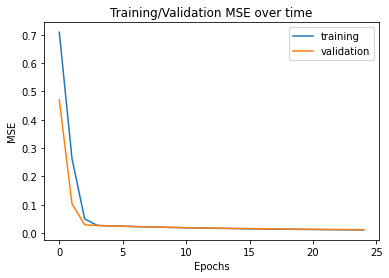

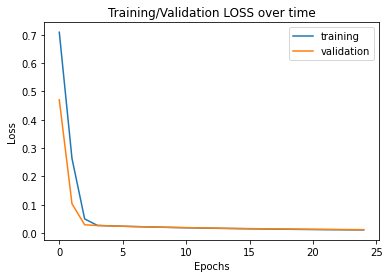

In [ ]:
#plot out mse
print('Final MSE of training data set: ' + str(np.mean(hist.history['mse'][-1])))
print('Final MSE of validation data set: ' + str(np.mean(hist.history['val_mse'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['mse'], label = 'training')
plt.plot(range(epochs), hist.history['val_mse'], label = 'validation')
plt.title('Training/Validation MSE over time')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')

#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation LOSS over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')



In [ ]:
model.save("gdrive/MyDrive/NLP_final_project/t_w2v_0mincount_regression_upvoteratio.pt")

INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/t_w2v_0mincount_regression_upvoteratio.pt/assets


In [ ]:
# x = t_val_num_comments.values

# preds = model.predict(t_val_post_embeddings)
# preds_diff = x - preds

# #get prediction if all mean
# preds_mean = [np.mean(x)]*len(x)
# preds_mean_diff = x - preds_mean

# preds_median = [np.median(x)]*len(x)
# preds_median_diff = x - preds_median

# plot = plt.figure(1)
# plt.hist(preds_mean_diff, bins=20)
# plt.title('Histogram of error when using mean as prediction ')
# plt.xlabel('Error')

# plot = plt.figure(2)
# plt.hist(preds_median_diff, bins=20)
# plt.title('Histogram of error when using median as prediction ')
# plt.xlabel('Error')

# plot = plt.figure(3)
# plt.hist(preds_diff, bins=20)
# plt.title('Histogram of error when using model as prediction ')
# plt.xlabel('Error')


###Classification for num_comments

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_features = i_train_post_embeddings_10.shape[1]
print(num_features)

epochs=35

model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))
# model.add(Dropout(rate=0.5))

#format output correctly (linear function)
# model.add(Dense(units=len(i_num_bins), activation='softmax', name='output_layer')) 
model.add(Dense(units=1, activation='sigmoid', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(lr=.0001)

model.compile(optimizer=opt, 
              # loss='categorical_crossentropy', #use mean squared error
              loss = 'binary_crossentropy',
              metrics=['accuracy','AUC' ]) 
# model.compile(optimizer=opt, 
#               loss='categorical_crossentropy', #use mean squared error
#               metrics=['accuracy']) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=i_train_post_embeddings_10, 
         y = np.array(i_train_upvote_ratio_2_10),
         batch_size=32,
         validation_data = (i_val_post_embeddings_10, np.array(i_val_upvote_ratio_2_10)),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

100
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=i_val_upvote_ratio_2_10

preds =model.predict(i_val_post_embeddings_10)
preds = np.round(preds)
correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print('Using model as prediction')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print('Using mean as prediction')
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print('Using median as prediction')
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print('Using mode as prediction')
print(sum([1 if i != -1 else 0 for i in correct]))

print('Total predictions')
print(len(preds))


Using model as prediction
1615
Using mean as prediction
1511
Using median as prediction
1511
Using mode as prediction
1511
Total predictions
2878


Final accuracy of training data set: 0.567030668258667
Final accuracy of validation data set: 0.5611535906791687

Final loss of training data set: 0.6800979375839233
Final loss of validation data set: 0.6845418810844421

Final AUC of training data set: 0.5880113840103149
Final AUC of validation data set: 0.5754038691520691



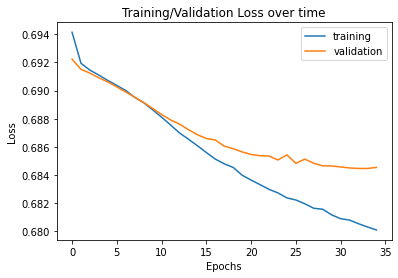

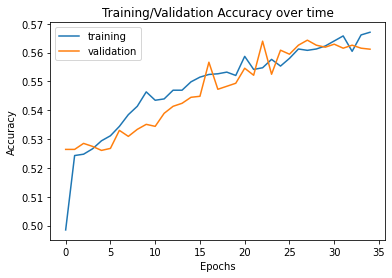

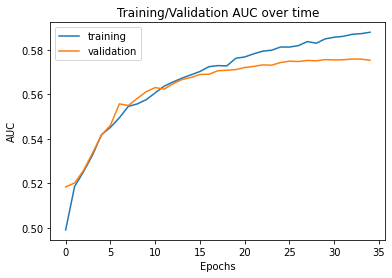

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss vs. epochs
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()
print('Final AUC of training data set: ' + str(hist.history['auc'][-1]))
print('Final AUC of validation data set: ' + str(hist.history['val_auc'][-1]))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plot_loss = plt.figure(3)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')

plt.show()

In [ ]:
model.save("gdrive/MyDrive/NLP_final_project/i_w2v_10mincount_binary_upvote")
# !ls

INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/i_w2v_10mincount_binary_upvote/assets


TTCAFTERLOSS

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_features = t_train_post_embeddings_10.shape[1]

epochs=20

#initialize regression model
model = Sequential()

#add layers
model.add(Dense(units=24, activation='linear', input_dim=num_features, name='hidden_layer_1'))
model.add(Dense(units=32, activation='relu', input_dim=24, name='hidden_layer_2'))
model.add(Dropout(rate=0.5))

#format output correctly (linear function)
# model.add(Dense(units=len(i_num_bins), activation='softmax', name='output_layer')) 
model.add(Dense(units=1, activation='sigmoid', name='output_layer')) 

#define optimizer function (stochastic gradient descent)
opt = Adam(lr=.0001)
# opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              # loss='categorical_crossentropy', #use mean squared error
              loss = 'binary_crossentropy',
              metrics=['accuracy','AUC' ]) 
# model.compile(optimizer=opt, 
#               loss='categorical_crossentropy', #use mean squared error
#               metrics=['accuracy']) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=t_train_post_embeddings_10, 
         y = np.array(t_train_upvote_ratio_2_10),
         batch_size=32,
         validation_data = (t_val_post_embeddings_10, np.array(t_val_upvote_ratio_2_10)),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 24)                2424      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                800       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=t_val_upvote_ratio_2_10

preds =model.predict(t_val_post_embeddings_10)
preds = np.round(preds)
correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))


print(len(preds))


1150
1150
1150
1150
1460


Final accuracy of training data set: 0.8036081194877625
Final accuracy of validation data set: 0.7876712083816528

Final loss of training data set: 0.5087966322898865
Final loss of validation data set: 0.5165573954582214

Final AUC of training data set: 0.49837809801101685
Final AUC of validation data set: 0.5263814926147461



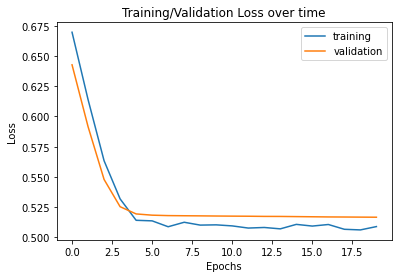

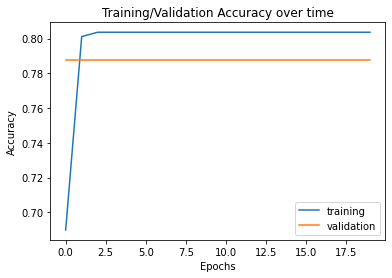

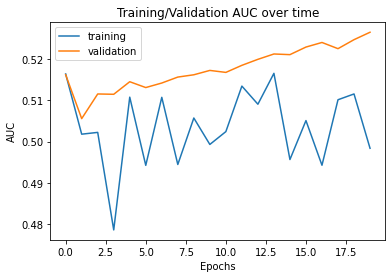

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss vs. epochs
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()
print('Final AUC of training data set: ' + str(hist.history['auc'][-1]))
print('Final AUC of validation data set: ' + str(hist.history['val_auc'][-1]))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plot_loss = plt.figure(3)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')

plt.show()

##Simple language model (LSTM) 

In [15]:
##generate whole post lists
import itertools

def post_from_sentence_tokenized(_texts, _tokenized, min_words):
  #get number of sentences per post
  num_sent_per_post = [post[0].count('], [') + 1 for post in _texts]

  #initialize return value and from index
  fr_index=0
  post_tokenized = []

  #get number of posts above threshold
  num_words_per_post = [post[0].count(' ') for post in _texts]
  above_thresh = [1 if i > min_words else 0 for i in num_words_per_post ]

  #SUM the corresponding number of sentence embeddings together to get post embeddings 
  for i in range(len(num_sent_per_post)):
    to_index = fr_index + num_sent_per_post[i]
    targ_sentences = _tokenized[fr_index:to_index + 1]
    targ_post = list(itertools.chain(*targ_sentences))
    fr_index = to_index + 1
    
    if above_thresh[i] == 1:
        post_tokenized.append(targ_post)
  return post_tokenized

In [16]:
i_train_post_tokenized_0 = post_from_sentence_tokenized(i_train_texts, i_tokenized_train, 0)
i_val_post_tokenized_0 = post_from_sentence_tokenized(i_val_texts, i_tokenized_val, 0)

t_train_post_tokenized_0 = post_from_sentence_tokenized(t_train_texts, t_tokenized_train, 0)
t_val_post_tokenized_0 = post_from_sentence_tokenized(t_val_texts, t_tokenized_train, 0)

In [51]:
len(np.where(combined_train > 16)[0])

4295

In [45]:
lens=[]
for i in i_train_post_tokenized_0:
  lens.append(len(i))
sum(lens)   / len(lens)

max(lens)

4613

In [17]:
#preprocessing, input into model is different than Word2vec. Needs integer-mapped and padded word sequences.
from tensorflow.keras.preprocessing.sequence import pad_sequences


#pad sequences
seq_len = 2000

i_train_padded = pad_sequences(i_train_post_tokenized_0, maxlen=seq_len)
i_val_padded = pad_sequences(i_val_post_tokenized_0, maxlen=seq_len)

t_train_padded = pad_sequences(t_train_post_tokenized_0, maxlen=seq_len)
t_val_padded = pad_sequences(t_val_post_tokenized_0, maxlen=seq_len)

#Model for regression - combined

In [123]:
topic_df = pd.read_csv('gdrive/MyDrive/NLP_final_project/10_all_posts_with_comment_topics.txt')
topic_df[topic_df.data_split == 'test'].shape
# topic_df.head()

(4461, 17)

In [18]:
#read in topic modeling outcomes
topic_df = pd.read_csv('gdrive/MyDrive/NLP_final_project/10_all_posts_with_comment_topics.txt')

topic_df = topic_df[["id", "max_mean_topic", "mode_max_topic"]]

infertility_train_new = infertility_train.merge(topic_df, on = "id") #lsuffix="id", rsuffix="id")
infertility_val_new = infertility_val.merge(topic_df, on = "id")
afterloss_train_new = afterloss_train.merge(topic_df, on = "id")
afterloss_val_new = afterloss_val.merge(topic_df, on = "id")

i_train_mode = infertility_train_new.mode_max_topic
i_val_mode = infertility_val_new.mode_max_topic
t_train_mode = afterloss_train_new.mode_max_topic
t_val_mode = afterloss_val_new.mode_max_topic

i_train_mean = infertility_train_new.max_mean_topic
i_val_mean = infertility_val_new.max_mean_topic
t_train_mean = afterloss_train_new.max_mean_topic
t_val_mean = afterloss_val_new.max_mean_topic

#get corresponding max mean topic ouTcome

num_words_per_post = np.array([post[0].count(' ') for post in i_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_train_mean_0 = np.take(i_train_mean, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in i_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_val_mean_0 = np.take(i_val_mean, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_train_mean_0 = np.take(t_train_mean, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_val_mean_0 = np.take(t_val_mean, filter_indices,0)

#get corresponding mode max topic outcome

num_words_per_post = np.array([post[0].count(' ') for post in i_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_train_mode_0 = np.take(i_train_mode, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in i_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_val_mode_0 = np.take(i_val_mode, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_train_mode_0 = np.take(t_train_mode, filter_indices,0)

num_words_per_post = np.array([post[0].count(' ') for post in t_val_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_val_mode_0 = np.take(t_val_mode, filter_indices,0)

In [18]:

# topic_df[topic_df.id == '2t6afv']
# # afterloss_val_new[afterloss_val_new.id== '2t6afv']

In [19]:
# topic_df = pd.read_csv('gdrive/MyDrive/NLP_final_project/10_all_posts_with_comment_topics.txt')
# topic_df.head(30)

In [19]:
num_words_per_post = np.array([post[0].count(' ') for post in i_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
i_ids = infertility_train_new.id.values
i_ids = np.take(i_ids, filter_indices)

num_words_per_post = np.array([post[0].count(' ') for post in t_train_texts])
filter_indices = np.where(num_words_per_post > threshold)[0].tolist()
t_ids = afterloss_train_new.id.values
t_ids = np.take(t_ids, filter_indices)

combined_ids = np.concatenate([i_ids, t_ids],axis=0)
print(combined_ids.shape)

# combined_train_posts.shape


(13237,)


In [20]:
##Dataset for both infertility and TTC
print(i_train_padded.shape, t_train_padded.shape)
combined_train_posts = np.concatenate([i_train_padded,t_train_padded], axis=0)

combined_val_posts = np.concatenate([i_val_padded,t_val_padded], axis=0)

print(i_reps_word2vec.shape, t_reps_word2vec.shape)
combined_reps = torch.cat([i_reps_word2vec, t_reps_word2vec], axis=1)
print(combined_reps.shape)

#outcome, comments
i_outcome, t_outcome = i_train_num_comments_0.values, t_train_num_comments_0.values
combined_train = np.concatenate([i_outcome, t_outcome], axis=0)

i_outcome, t_outcome = i_val_num_comments_0.values, t_val_num_comments_0.values
combined_val = np.concatenate([i_outcome, t_outcome], axis=0)

#outcome, upvote ratio
i_outcome_vote, t_outcome_vote = i_train_upvote_ratio_0.values, t_train_upvote_ratio_0.values
combined_train_uv = np.concatenate([i_outcome_vote, t_outcome_vote], axis=0)

i_outcome_vote, t_outcome_vote = i_val_upvote_ratio_0.values, t_val_upvote_ratio_0.values
combined_val_uv = np.concatenate([i_outcome_vote, t_outcome_vote], axis=0)

#outcome, topic max mean 
i_outcome_vote, t_outcome_vote = i_train_mean_0.values, t_train_mean_0.values
combined_train_mean = np.concatenate([i_outcome_vote, t_outcome_vote], axis=0)

i_outcome_vote, t_outcome_vote = i_val_mean_0.values, t_val_mean_0.values
combined_val_mean = np.concatenate([i_outcome_vote, t_outcome_vote], axis=0)

#outcome, topic mode max  
i_outcome_vote, t_outcome_vote = i_train_mode_0.values, t_train_mode_0.values
combined_train_mode = np.concatenate([i_outcome_vote, t_outcome_vote], axis=0)

i_outcome_vote, t_outcome_vote = i_val_mode_0.values, t_val_mode_0.values
combined_val_mode = np.concatenate([i_outcome_vote, t_outcome_vote], axis=0)





(8815, 2000) (4422, 2000)
torch.Size([10000, 100]) torch.Size([10000, 100])
torch.Size([10000, 200])


In [21]:
#find posts with with 0 comments, for topic outcomes only

filter_indices = np.where(np.invert(np.isnan(combined_train_mean)))[0].tolist()
combined_train_posts_wcomments = np.take(combined_train_posts, filter_indices,0)
combined_train_mean = np.take(combined_train_mean, filter_indices,0)
combined_train_mode = np.take(combined_train_mode, filter_indices,0)

combined_ids_wcomments = np.take(combined_ids, filter_indices,0)

filter_indices = np.where(np.invert(np.isnan(combined_val_mean)))[0].tolist()
combined_val_posts_wcomments = np.take(combined_val_posts, filter_indices,0)
combined_val_mean = np.take(combined_val_mean, filter_indices,0)
combined_val_mode = np.take(combined_val_mode, filter_indices,0)


#binarize topic mean and mode

from sklearn.preprocessing import LabelBinarizer
topic_transformer = LabelBinarizer()

combined_train_mean_binarized = topic_transformer.fit_transform(combined_train_mean)
combined_val_mean_binarized = topic_transformer.fit_transform(combined_val_mean)

combined_train_mode_binarized = topic_transformer.fit_transform(combined_train_mode)
combined_val_mode_binarized = topic_transformer.fit_transform(combined_val_mode)

In [22]:
#binarize upvote bins

combined_train_uv_binned

from sklearn.preprocessing import LabelBinarizer
uv_transformer = LabelBinarizer()

combined_train_uv_binarized = uv_transformer.fit_transform(combined_train_uv_binned)
combined_val_uv_binarized = uv_transformer.fit_transform(combined_val_uv_binned)


NameError: ignored

Load saved models, if any

In [31]:
vote_model = load_model('gdrive/MyDrive/NLP_final_project/it_lstm_0mincount_regression_upvote_NEW')
vote_model.summary()

new_model= Model(inputs=vote_model.input, outputs=vote_model.layers[-2].output)
new_model.summary()

results = vote_model.evaluate(combined_val_posts, combined_val_uv_binarized, batch_size=128)
print(results)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                4440      
_________________________________________________________________
output_layer (Dense)         (None, 3)                 33        
Total params: 1,004,473
Trainable params: 1,004,473
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2000)]            0         
__________________________________

In [35]:
# preds = comments_model.predict(combined_train_posts)
# preds = preds.flatten()


# train_comments_embeddings = new_model.predict(combined_train_posts)
train_vote_embeddings = new_model.predict(combined_train_posts)


#for upvote ratio, add a layer thats sigmoid and get predictions from that
 



Get LSTM embeddings

In [40]:
combined_val_posts_wcomments.shape
combined_val_posts.shape

(4417, 2000)

In [69]:
preds = vote_model.predict(combined_val_posts)
preds = preds.flatten()
preds = np.round(preds,2) #comment out for upvote ratio
# np.where(preds > 1)

In [70]:
# train_comments_embeddings = new_model.predict(combined_train_posts)

from sklearn.metrics import r2_score
from scipy import stats

x=combined_val_uv

# preds = np.round(preds,1)

print('R squared: '+str(r2_score(x, preds)))
print()
pr = stats.pearsonr(x, preds)
print('Pearson correlation: '+str(pr))
print()

print('Baseline check')

correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print('model:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print('mean:')
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print('median:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print('mode:')
print(sum([1 if i != -1 else 0 for i in correct]))
print()
print('total:')
print(len(preds))


R squared: -0.21609561654904752

Pearson correlation: (0.06120152094833422, 4.698309977703233e-05)

Baseline check
model:
0
mean:
1818
median:
1818
mode:
1818

total:
4417


In [ ]:
topic_df[['id', 'mode_max_topic']]

,id,mode_max_topic
0,2t6afv,4.0
1,2t5c8b,0.0
2,2t2ksx,4.0
3,2t0gqy,8.0
4,2sy3ig,2.0
...,...,...
22290,itd64i,2.0
22291,it51cm,6.0
22292,it1qee,4.0
22293,it13dn,NaN


In [ ]:
topic_df.head()

,id,max_mean_topic,mode_max_topic
0,2t6afv,4.0,4.0
1,2t5c8b,4.0,0.0
2,2t2ksx,4.0,4.0
3,2t0gqy,8.0,8.0
4,2sy3ig,7.0,2.0


In [38]:
#create new df
new_df = pd.DataFrame({'id': combined_ids, 
                       'embedding': train_vote_embeddings.tolist(), 
                       'prediction': preds.tolist(),
                       'ground_truth': combined_train_uv_binned.tolist()})
topic_df = pd.read_csv('gdrive/MyDrive/NLP_final_project/10_all_posts_with_comment_topics.txt')
sub_df = topic_df[['id', 'upvote_ratio']]
# new_df = new_df.merge(sub_df,on='id')
print(new_df.shape)

# save df
new_df.to_csv('gdrive/MyDrive/NLP_final_project/LSTM_post_embeddings_with_categorical_voteratio_NEW.csv')

new_df.head()

(13237, 4)


,id,embedding,prediction,ground_truth
0,2t6u8l,"[-0.22501684725284576, -0.029330583289265633, ...",2,2
1,2t57np,"[0.2813028395175934, 0.012974992394447327, -0....",0,2
2,2t45rt,"[0.07794638723134995, 0.22722329199314117, -0....",2,2
3,2t3x6r,"[-0.35747987031936646, -0.19822020828723907, -...",0,0
4,2t35o4,"[-0.12524530291557312, -0.040538836270570755, ...",0,0


In [154]:
import tensorflow.keras as K


vocab_size=10000
embedding_dim = 100*2

# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), dtype='int32')
combined_reps = torch.cat([i_reps_word2vec , t_reps_word2vec],dim=1)

#combine embeddings by averaging (NOT concatenation)
combined_reps = (i_reps_word2vec + t_reps_word2vec)/2
embedding_dim = 100

weight = combined_reps
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       weights=[weight.detach().numpy()], name='embedding')(input)
# x = K.layers.Bidirectional(K.layers.LSTM(units = 10, dropout=0.5))(x)  
x = K.layers.LSTM(units = 20, dropout=0.5)(x)  
# x = K.layers.Dropout(rate=0.5)(x)
# x = K.layers.Dense(8, activation= 'relu' ) (x)
# x = K.layers.Dropout(rate=0.5)(x)

x = K.layers.Dense(units=3, 
                   activation='softmax', 
                   name='output_layer')(x)

# x = K.layers.Dense(units=1, 
#                    activation='linear',
#                    name='output_layer')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

opt = Adam(lr=.001)
epochs=5


model.compile(optimizer=opt, 
              # loss='mean_absolute_error', #use mean squared error
              
              loss = 'categorical_crossentropy',
              metrics=[K.metrics.Precision(),
              K.metrics.Recall(),
              'accuracy']
              ) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=combined_train_posts, 
         y = combined_train_uv_binarized,
         batch_size=128,
         validation_data = (combined_val_posts, combined_val_uv_binarized),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                9680      
_________________________________________________________________
output_layer (Dense)         (None, 3)                 63        
Total params: 1,009,743
Trainable params: 1,009,743
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2000)]            0         
________________________________

In [155]:
hist.history
# model.save("gdrive/MyDrive/NLP_final_project/it_lstm_0mincount_categorical_upvote_NEW")

{'accuracy': [0.3849814832210541,
  0.4106670618057251,
  0.4262295067310333,
  0.4319709837436676,
  0.44428494572639465],
 'loss': [1.1111871004104614,
  1.079615592956543,
  1.0692126750946045,
  1.0582934617996216,
  1.0500905513763428],
 'precision_3': [0.42146506905555725,
  0.47545111179351807,
  0.5065104365348816,
  0.5308798551559448,
  0.5432323813438416],
 'recall_3': [0.09345018118619919,
  0.08559340983629227,
  0.08816196769475937,
  0.09481000155210495,
  0.11248772591352463],
 'val_accuracy': [0.4239327907562256,
  0.4275658428668976,
  0.43801090121269226,
  0.4339236915111542,
  0.43710264563560486],
 'val_loss': [1.0816166400909424,
  1.0735565423965454,
  1.0667470693588257,
  1.0655778646469116,
  1.061983585357666],
 'val_precision_3': [0.4768568277359009,
  0.4829600751399994,
  0.4978601932525635,
  0.49049049615859985,
  0.5063451528549194],
 'val_recall_3': [0.10059037059545517,
  0.1126248836517334,
  0.0792461410164833,
  0.1112624853849411,
  0.09059945493

Final accuracy of training data set: 0.44428494572639465
Final accuracy of validation data set: 0.43710264563560486

Final loss of training data set: 1.0500905513763428
Final loss of validation data set: 1.061983585357666



Text(0.5, 0, 'Epochs')

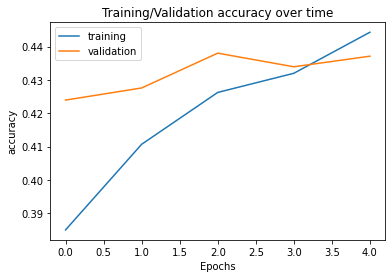

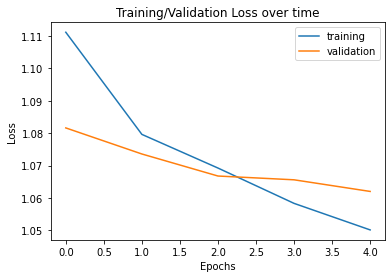

In [156]:
import matplotlib.pyplot as plt

#plot out mse
print('Final accuracy of training data set: ' + str(np.mean(hist.history['accuracy'][-1])))
print('Final accuracy of validation data set: ' + str(np.mean(hist.history['val_accuracy'][-1])))
print()
print('Final loss of training data set: ' + str(np.mean(hist.history['loss'][-1])))
print('Final loss of validation data set: ' + str(np.mean(hist.history['val_loss'][-1])))
print()
# print('Final precision of training data set: ' + str(np.mean(hist.history['precision_1'][-1])))
# print('Final precision of validation data set: ' + str(np.mean(hist.history['val_precision_1'][-1])))
# print()
# print('Final recall of training data set: ' + str(np.mean(hist.history['recall_1'][-1])))
# print('Final recall of validation data set: ' + str(np.mean(hist.history['val_recall_1'][-1])))
# print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation accuracy over time')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('Epochs')

#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

Final mae of training data set: 10.813508033752441
Final mae of validation data set: 10.380990982055664



Text(0.5, 0, 'Epochs')

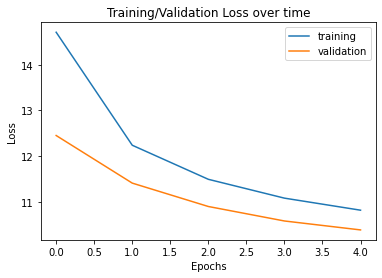

In [27]:
import matplotlib.pyplot as plt

#plot out mse
print('Final mae of training data set: ' + str(np.mean(hist.history['loss'][-1])))
print('Final mae of validation data set: ' + str(np.mean(hist.history['val_loss'][-1])))
print()
#plot model loss over training and val
# plot_loss = plt.figure(1)
# plt.plot(range(epochs), hist.history['mae'], label = 'training')
# plt.plot(range(epochs), hist.history['val_mae'], label = 'validation')
# plt.title('Training/Validation MAE over time')
# plt.legend()
# plt.ylabel('MAE')
# plt.xlabel('Epochs')

#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(x, preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

for i in range(10):
  print(i)
  print(len(np.where(preds == i)[0]))

[0.01140684 0.15975104 0.05088496 0.48547718 0.27232796 0.00671141
 0.6866417  0.00917431 0.50218341 0.16770186]
0
13
1
272
2
91
3
641
4
556
5
4
6
1266
7
7
8
1128
9
332


In [166]:
x=combined_val_mode
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(combined_val_mode))]
print('median:')
print(sum([1 if i != -1 else 0 for i in correct]))
result=precision_recall_fscore_support(x, preds_median, average='macro')
print(result)

median:
602
(0.14055568526733597, 0.14055568526733597, 0.14055568526733597, None)


In [35]:
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.metrics import precision_recall_fscore_support

x=combined_val_mode


# preds = vote_model.predict(combined_train_posts)

# non_binarized = uv_transformer.inverse_transform(preds)

# result=precision_recall_fscore_support(x, non_binarized, average='macro')
# print(result)


# preds = non_binarized


# print('Baseline check')

# correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
# print('model:')
# print(sum([1 if i != -1 else 0 for i in correct]))


# #get accuracy if use mean as prediction

# preds_mean = [np.round(np.mean(x))]*len(x)
# correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
# print('mean:')
# print(sum([1 if i != -1 else 0 for i in correct]))

# #get accuracy if use median as prediction
# preds_median = [np.round(np.median(x))]*len(x)
# correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
# print('median:')


#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(x))]
print('mode:')
print(sum([1 if i != -1 else 0 for i in correct]))
result=precision_recall_fscore_support(x, preds_mode, average='macro')
print(result)

print()
print('total:')
print(len(x))


mode:
801
(0.018584686774941996, 0.1, 0.03134415965564468, None)

total:
4310


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [160]:
print(1925/4404, 1856/4404)

0.43710263396911897 0.4214350590372389


##Model for regression task - infertility

In [ ]:
import tensorflow.keras as K

vocab_size = 10000
embedding_dim = 100

# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), dtype='int32')

weight = i_reps_word2vec
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       weights=[weight.detach().numpy()], name='embedding')(input)
x = K.layers.Bidirectional(K.layers.LSTM(units = 15))(x)   #make bidirectional=True
# x = K.layers.LSTM(units = 128) (x)
x = K.layers.Dropout(rate=0.5)(x)

x = K.layers.Dense(units=1, activation='linear', 
                   name='output_layer')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

opt = Adam(learning_rate=.001)
epochs=16

model.compile(optimizer=opt, 
              loss='mean_absolute_error', #use mean squared error
              metrics=['mse' ]) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=i_train_padded, 
         y = i_train_num_comments_0,
         batch_size=32,
         validation_data = (i_val_padded, i_val_num_comments_0),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

# torch.save(model.state_dict(), 'gdrive/MyDrive/NLP_final_project/infertility_comments_regression_LSTM_001.pt')
            

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 30)                13920     
_________________________________________________________________
dropout_31 (Dropout)         (None, 30)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 31        
Total params: 1,013,951
Trainable params: 1,013,951
Non-trainable params: 0
_________________________________________________________________
Model: "model_28"
_________________________________________________________________
Layer (type)                 O

In [ ]:
# torch.save(model, 'gdrive/MyDrive/NLP_final_project/i_lstm_0mincount_regression_comments.pt')
model.save("gdrive/MyDrive/NLP_final_project/i_lstm_0mincount_regression_comments")

INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/i_lstm_0mincount_regression_comments/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/i_lstm_0mincount_regression_comments/assets


In [ ]:
hist.history

{'loss': [10.980110168457031,
  10.45250415802002,
  10.250244140625,
  10.060075759887695,
  9.822985649108887,
  9.529414176940918,
  9.365511894226074,
  9.14530086517334,
  8.928955078125,
  8.728334426879883,
  8.560909271240234,
  8.386664390563965,
  8.237051963806152,
  8.088775634765625,
  7.94495964050293],
 'mae': [10.980110168457031,
  10.45250415802002,
  10.250244140625,
  10.060075759887695,
  9.822985649108887,
  9.529414176940918,
  9.365511894226074,
  9.14530086517334,
  8.928955078125,
  8.728334426879883,
  8.560909271240234,
  8.386664390563965,
  8.237051963806152,
  8.088775634765625,
  7.94495964050293],
 'val_loss': [10.01075267791748,
  9.929590225219727,
  9.8883056640625,
  9.816981315612793,
  9.855422973632812,
  9.837496757507324,
  9.98033332824707,
  9.885926246643066,
  9.947491645812988,
  9.930375099182129,
  10.042360305786133,
  10.035487174987793,
  10.163331985473633,
  10.120118141174316,
  10.023557662963867],
 'val_mae': [10.01075267791748,
 

Final MSE of training data set: 7.94495964050293
Final MSE of validation data set: 10.023557662963867



Text(0.5, 0, 'Epochs')

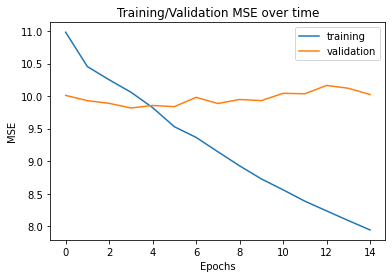

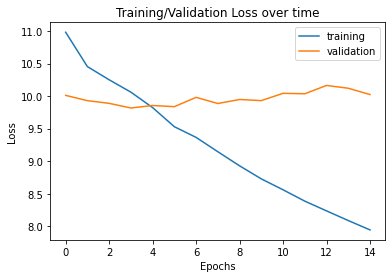

In [ ]:
import matplotlib.pyplot as plt

#plot out mse
print('Final MSE of training data set: ' + str(np.mean(hist.history['mae'][-1])))
print('Final MSE of validation data set: ' + str(np.mean(hist.history['val_mae'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['mae'], label = 'training')
plt.plot(range(epochs), hist.history['val_mae'], label = 'validation')
plt.title('Training/Validation MSE over time')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')

#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')





In [ ]:
from sklearn.metrics import r2_score
from scipy import stats

x=i_val_num_comments_0.values

preds = model.predict(i_val_post_embeddings_0)
preds = preds.flatten()
preds = np.round(preds,2) #comment out for upvote ratio

print('R squared: '+str(r2_score(x, preds)))
print()
pr = stats.pearsonr(x, preds)
print('Pearson correlation: '+str(pr))
print()

print('Baseline check')

correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print('model:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print('mean:')
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print('median:')
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print('mode:')
print(sum([1 if i != -1 else 0 for i in correct]))
print()
print('total:')
print(len(preds))


KeyError: ignored

In [ ]:
model.save('gdrive/MyDrive/NLP_final_project/infertility_comments_regression_LSTM_001.pt')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/infertility_comments_regression_LSTM_001.pt/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/NLP_final_project/infertility_comments_regression_LSTM_001.pt/assets


In [ ]:
infertility_train[infertility_train.id == "2t45rt"]

,Unnamed: 0,id,created_utc,author,author_fullname,author_flair_text,url,title,selftext,upvote_ratio,score,num_comments,data_split,processed_text,processed_title
3,5,2t45rt,1.421801e+09,Pamzella,t2_aifrd,41 MFI & DOR 1MC mult IUIs,https://www.reddit.com/r/infertility/comments/...,"""Shared risk"" clinics","Please educate me, someone asked me about this...",1.0,7,17,train,"[['please', 'educate', 'I', 'someone', 'ask', ...","[['share', 'risk', 'clinic']]"


Text(0.5, 0, 'Error')

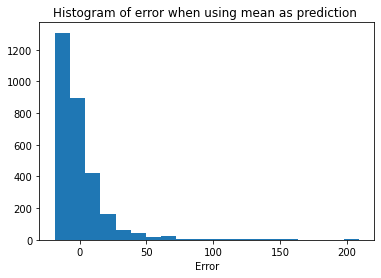

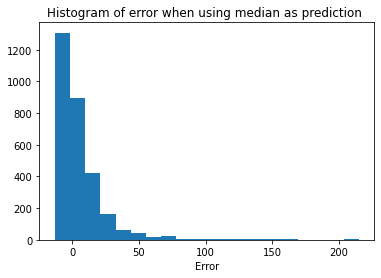

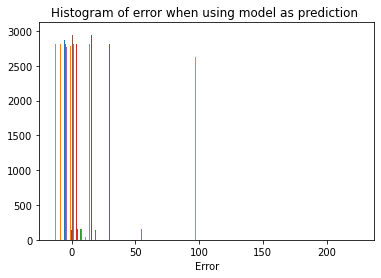

In [ ]:
# x = i_val_num_comments.values

# preds = model.predict(i_val_padded)
# preds_diff = x - preds

# #get prediction if all mean
# preds_mean = [np.mean(x)]*len(x)
# preds_mean_diff = x - preds_mean

# preds_median = [np.median(x)]*len(x)
# preds_median_diff = x - preds_median

# plot = plt.figure(1)
# plt.hist(preds_mean_diff, bins=20)
# plt.title('Histogram of error when using mean as prediction ')
# plt.xlabel('Error')

# plot = plt.figure(2)
# plt.hist(preds_median_diff, bins=20)
# plt.title('Histogram of error when using median as prediction ')
# plt.xlabel('Error')

# plot = plt.figure(3)
# plt.hist(preds_diff, bins=20)
# plt.title('Histogram of error when using model as prediction ')
# plt.xlabel('Error')


In [ ]:
# from sklearn.linear_model import LinearRegression

# reg = LinearRegression().fit(i_train_padded, i_train_num_comments.values)

# r2 = reg.score(i_train_padded, i_train_num_comments.values)

# preds = reg.predict(i_val_padded)

# round_preds = np.round(preds)

# #calculate number of correct predictions
# num_correct_preds = sum([1 if i_val_num_comments.values[i] == round_preds[i] else 0 for i in range(len(round_preds))])


In [ ]:
print(len(i_val_num_comments), len(round_preds))

# i_val_num_comments.values
print(num_correct_preds)
num_correct_preds / len(i_val_num_comments)

2977 2977
66


0.022169969768223042

In [ ]:

#get predictions
test_predictions = model.predict(i_val_padded).flatten()
round_preds = np.round(test_predictions)

#calculate number of correct predictions
num_correct_preds   = sum([1 if i_val_num_comments.values[i] == round_preds[i] else 0 for i in range(len(round_preds))])

print(num_correct_preds)
print(num_correct_preds/len(round_preds))

#Get prediction error histogram
from matplotlib.pyplot import figure
figure(figsize=(10, 10))


#compare predictions to actual labels
error = test_predictions - i_val_num_comments.values


plt.hist(error, bins=35)
plt.xlabel('Error')
_ = plt.ylabel('Count')
plt.title('Distribution of Prediction Error for infertility (n = 2977) ')
plt.show()

99
0.033254954652334565


AttributeError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
np.median(error)

-0.16881656646728516

##Model for regression task - ttcafterloss

In [ ]:
import tensorflow.keras as K

vocab_size = 10000
embedding_dim = 100

# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), dtype='int32')

weight = t_reps_word2vec
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       weights=[weight.detach().numpy()], name='embedding')(input)
x = K.layers.Bidirectional(K.layers.LSTM(units = 15))(x)   #make bidirectional=True
# x = K.layers.LSTM(units = 128) (x)
x = K.layers.Dropout(rate=0.5)(x)

x = K.layers.Dense(units=1, activation='linear', 
                   name='output_layer')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

opt = Adam(learning_rate=.001)
epochs=16

model.compile(optimizer=opt, 
              loss='mean_squared_error', #use mean squared error
              metrics=['mse' ]) 
model.summary() 

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=t_train_padded, 
         y = t_train_num_comments_0,
         batch_size=32,
         validation_data = (t_val_padded, t_val_num_comments_0),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

# torch.save(model.state_dict(), 'gdrive/MyDrive/NLP_final_project/infertility_comments_regression_LSTM_001.pt')
            

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 30)                13920     
_________________________________________________________________
dropout_32 (Dropout)         (None, 30)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 31        
Total params: 1,013,951
Trainable params: 1,013,951
Non-trainable params: 0
_________________________________________________________________
Model: "model_29"
_________________________________________________________________
Layer (type)                 O

In [ ]:
model.save('gdrive/MyDrive/NLP_final_project/t_lstm_0mincount_regression_comments')

Final MSE of training data set: 65.48932647705078
Final MSE of validation data set: 94.78543853759766



KeyError: ignored

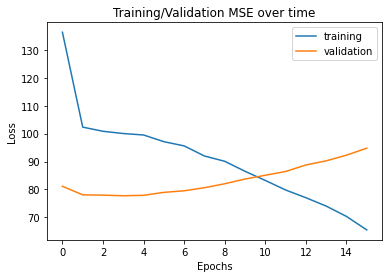

In [ ]:

import matplotlib.pyplot as plt

#plot out mse
print('Final MSE of training data set: ' + str(np.mean(hist.history['mse'][-1])))
print('Final MSE of validation data set: ' + str(np.mean(hist.history['val_mse'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['mse'], label = 'training')
plt.plot(range(epochs), hist.history['val_mse'], label = 'validation')
plt.title('Training/Validation MSE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot out mae
print('Final MAE of training data set: ' + str(np.mean(hist.history['mae'][-1])))
print('Final MAE of validation data set: ' + str(np.mean(hist.history['val_mae'][-1])))
print()
#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['mae'], label = 'training')
plt.plot(range(epochs), hist.history['val_mae'], label = 'validation')
plt.title('Training/Validation MAE over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')





In [ ]:
preds = model.predict(t_val_padded)
preds_round = np.round(preds)
preds_round = preds_round.flatten()

correct = [preds_round[i] if preds_round[i] == t_val_num_comments.values[i] else -1 for i in range(len(preds))]
print(correct)
# np.count_nonzero(correct)
import collections

print(collections.Counter(correct))

print(sum([1 if i != -1 else 0 for i in correct]))
len(correct)

[-1, -1, -1, -1, 11.0, 5.0, -1, -1, -1, -1, -1, -1, -1, -1, 7.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5.0, -1, -1, -1, -1, -1, -1, 9.0, -1, -1, -1, -1, -1, -1, -1, 9.0, -1, -1, -1, 11.0, -1, -1, -1, -1, 8.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8.0, -1, -1, -1, -1, -1, 5.0, -1, -1, -1, -1, 8.0, -1, -1, -1, -1, -1, -1, -1, -1, 7.0, -1, -1, 7.0, -1, -1, -1, -1, -1, -1, -1, 6.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11.0, -1, -1, -1, 6.0, -1, -1, -1, -1, -1, -1, 8.0, -1, -1, -1, -1, -1, -1, -1, -1, 4.0, 5.0, -1, -1, -1, -1, 7.0, -1, -1, -1, 9.0, -1, -1, 10.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 9.0,

1481

In [ ]:
#get accuracy if use mean as prediction
x=t_val_num_comments.values
preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
print(preds_mode)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(x))]
print(sum([1 if i != -1 else 0 for i in correct]))

72
90
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

##Model for categorical task, bin outcomes

Bin outcomes

In [ ]:
# i_abs_max = np.amax([max(i_train_num_comments), max(i_val_num_comments)])
# t_abs_max = np.amax([max(t_train_num_comments), max(t_val_num_comments)])
# print(i_abs_max, t_abs_max)

# i_abs_max = np.amax([max(i_train_num_comments), max(i_val_num_comments)])
# t_abs_max = np.amax([max(t_train_num_comments), max(t_val_num_comments)])

# hist_i_train_comments = np.histogram(i_train_num_comments, bins=8, range=(0, i_abs_max), weights=None)
# hist_i_val_comments = np.histogram(i_val_num_comments, bins=8, range=(0, i_abs_max), weights=None)

# hist_t_train_comments = np.histogram(t_train_num_comments, bins=8, range=(0, t_abs_max), weights=None)
# hist_t_val_comments = np.histogram(t_val_num_comments, bins=8, range=(0, t_abs_max), weights=None)

# print(hist_i_train_comments)
# print(hist_i_val_comments)
# print(hist_t_train_comments)
# print(hist_t_val_comments)

565 113
(array([8686,  186,   44,   10,    5,    0,    0,    1]), array([  0.   ,  70.625, 141.25 , 211.875, 282.5  , 353.125, 423.75 ,
       494.375, 565.   ]))
(array([2899,   60,   16,    2,    0,    0,    0,    0]), array([  0.   ,  70.625, 141.25 , 211.875, 282.5  , 353.125, 423.75 ,
       494.375, 565.   ]))
(array([3371,  841,  169,   35,   20,    4,    1,    3]), array([  0.   ,  14.125,  28.25 ,  42.375,  56.5  ,  70.625,  84.75 ,
        98.875, 113.   ]))
(array([1147,  272,   51,    5,    4,    2,    0,    0]), array([  0.   ,  14.125,  28.25 ,  42.375,  56.5  ,  70.625,  84.75 ,
        98.875, 113.   ]))


In [ ]:
# #customize bins
# i_num_bins = [10,20,30,40,50,60,70,80,90,100]
# t_num_bins = [10,20,30,40,50,60,70]

# def find_nearest(array,value):
#   idx = (np.abs(array-np.ceil(value))).argmin()
#   return array[idx]

# bin_i_train_comments = [find_nearest(i_num_bins, x) for x in i_train_num_comments]
# bin_i_val_comments = [find_nearest(i_num_bins, x) for x in i_val_num_comments]

# bin_t_train_comments = [find_nearest(t_num_bins, x) for x in t_train_num_comments]
# bin_t_val_comments = [find_nearest(t_num_bins, x) for x in t_val_num_comments]

# #binarize labels
# from sklearn.preprocessing import LabelBinarizer
# label_transformer = LabelBinarizer()

# binary_i_train_comments = label_transformer.fit_transform(bin_i_train_comments)
# binary_i_val_comments = label_transformer.fit_transform(bin_i_val_comments)

# binary_t_train_comments = label_transformer.fit_transform(bin_t_train_comments)
# binary_t_val_comments = label_transformer.fit_transform(bin_t_val_comments)


New binning methods, makes equal size bins

In [ ]:
# data = i_train_num_comments
# # parameter q specifies the number of bins
# qc = pd.qcut(data, q=6, precision=1)

# # bin definition
# bins  = qc.cat.categories
# print(bins)

# # bin corresponding to each point in data
# newbin_i_train_comments = qc.cat.codes

# #define for val
# i_newbins = [0, 5, 9, 13, 18, 29]
# newbin_i_val_comments = [find_nearest(i_newbins, x) for x in i_val_num_comments]

# newbinary_i_train_comments = label_transformer.fit_transform(newbin_i_train_comments)
# newbinary_i_val_comments = label_transformer.fit_transform(newbin_i_val_comments)

In [23]:
combined_train_uv_binned=[]
for i in combined_train_uv:
  if i < 0.86: combined_train_uv_binned.append(0)
  elif i < 1: combined_train_uv_binned.append(1)
  else: combined_train_uv_binned.append(2)

combined_val_uv_binned=[]
for i in combined_val_uv:
  if i < 0.86: combined_val_uv_binned.append(0)
  elif i < 1: combined_val_uv_binned.append(1)
  else: combined_val_uv_binned.append(2) 

combined_train_uv_binned = np.array(combined_train_uv_binned)
combined_val_uv_binned = np.array(combined_val_uv_binned)  

In [31]:
data = pd.Series(combined_train)
# parameter q specifies the number of bins
qc = pd.qcut(data, q=6, precision=1)

# bin definition
bins  = qc.cat.categories
print(bins)

# bin corresponding to each point in data
newbin_train_comments = qc.cat.codes

#define for val
combined_newbins = [4, 8, 11, 16, 25, 565]

#get values
l_train = [combined_newbins[k] for k in np.searchsorted(combined_newbins, data)]
#map values to right bins
df = pd.DataFrame({'x': l_train})
# print(df)
df = df.replace([5, 9, 13, 18, 29, 565], [0, 1, 2, 3, 4, 5])
newbin_train_comments = df.x.values

data = pd.Series(combined_val)

#get values
l_val = [combined_newbins[k] for k in np.searchsorted(combined_newbins, data)]
#map values to right bins
df = pd.DataFrame({'x': l_val})
# print(df)
df = df.replace([5, 9, 13, 18, 29, 565], [0, 1, 2, 3, 4, 5])
newbin_val_comments = df.x.values

#binarize labels
from sklearn.preprocessing import LabelBinarizer
label_transformer = LabelBinarizer()

newbinary_train_comments = label_transformer.fit_transform(newbin_train_comments)
newbinary_val_comments = label_transformer.fit_transform(newbin_val_comments)

IntervalIndex([(-0.1, 4.0], (4.0, 8.0], (8.0, 11.0], (11.0, 16.0], (16.0, 25.0], (25.0, 565.0]],
              closed='right',
              dtype='interval[float64]')


In [ ]:
preds

array([[0.22290622, 0.09837801, 0.23906049, 0.1468916 , 0.15497226,
        0.13779141],
       [0.14484702, 0.16286357, 0.23304744, 0.1297376 , 0.17526384,
        0.15424065],
       [0.1900869 , 0.12710612, 0.20872194, 0.15576504, 0.13572286,
        0.1825971 ],
       ...,
       [0.12760602, 0.19212817, 0.22860803, 0.13351412, 0.15918961,
        0.15895407],
       [0.14145711, 0.21635255, 0.17639515, 0.12203903, 0.15703405,
        0.18672214],
       [0.18368964, 0.16177253, 0.19827347, 0.12039989, 0.16693448,
        0.16893   ]], dtype=float32)

In [ ]:
data = t_train_num_comments
# parameter q specifies the number of bins
qc = pd.qcut(data, q=6, precision=1)

# bin definition
bins  = qc.cat.categories
print(bins)

# bin corresponding to each point in data
newbin_t_train_comments = qc.cat.codes

#define for val
t_newbins = [3, 6, 8, 12, 18, 113]

#get values
l_train = [t_newbins[k] for k in np.searchsorted(t_newbins, t_train_num_comments)]
#map values to right bins
df = pd.DataFrame({'x': l_train})
# print(df)
df = df.replace(t_newbins, [0, 1, 2, 3, 4, 5])
newbin_t_train_comments = df.x.values

#get values
l_val = [t_newbins[k] for k in np.searchsorted(t_newbins, t_val_num_comments)]
#map values to right bins
df = pd.DataFrame({'x': l_val})
# print(df)
df = df.replace(t_newbins, [0, 1, 2, 3, 4, 5])
newbin_t_val_comments = df.x.values

#binarize labels
from sklearn.preprocessing import LabelBinarizer
label_transformer = LabelBinarizer()

newbinary_t_train_comments = label_transformer.fit_transform(newbin_t_train_comments)
newbinary_t_val_comments = label_transformer.fit_transform(newbin_t_val_comments)

IntervalIndex([(-0.1, 3.0], (3.0, 6.0], (6.0, 8.0], (8.0, 12.0], (12.0, 18.0], (18.0, 113.0]],
              closed='right',
              dtype='interval[float64]')


In [ ]:
np.sum(newbinary_i_train_comments, axis=0)

array([1554, 1598, 1417, 1300, 1531, 1415])

In [ ]:
import tensorflow.keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Recall, Precision


epochs=5
vocab_size = 10000
embedding_dim = 100
seq_len=2000

# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), dtype='int32')

weight = i_reps_word2vec
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       weights=[weight.detach().numpy()], name='embedding')(input)
x = K.layers.Bidirectional(K.layers.LSTM(units = 30))(x)   #make bidirectional=True
x = K.layers.Dropout(rate=0.5)(x)


x = K.layers.Dense(units=len(i_newbins), activation='softmax',  name='output_layer')(x)
# x = K.layers.Dense(units=1, activation='sigmoid',  name='output_layer')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

opt = Adam(lr=.001)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy', #use mean squared error
              metrics=['accuracy', Precision() , Recall()
                       ])  #AUC, accuracy, loss

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=i_train_padded, 
         y = newbinary_i_train_comments,
         batch_size=32,
         validation_data = (i_val_padded, newbinary_i_val_comments),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

# model.save('gdrive/MyDrive/NLP_final_project/infertility_comments_classif_LSTM_001.pt')


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 60)                31440     
_________________________________________________________________
dropout_21 (Dropout)         (None, 60)                0         
_________________________________________________________________
output_layer (Dense)         (None, 6)                 366       
Total params: 1,031,806
Trainable params: 1,031,806
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: ignored

Multiclass outcome (n=6)

In [ ]:
hist.history

{'auc': [0.5271155834197998,
  0.5901338458061218,
  0.6295017004013062,
  0.6563419103622437,
  0.686734139919281],
 'loss': [1.8109698295593262,
  1.7475783824920654,
  1.7070376873016357,
  1.6713999509811401,
  1.628830909729004],
 'precision_5': [0.6129032373428345,
  0.9466666579246521,
  0.802395224571228,
  0.7647058963775635,
  0.7331838607788086],
 'recall_5': [0.002155416877940297,
  0.008054452948272228,
  0.015201360918581486,
  0.025070901960134506,
  0.03709585964679718],
 'val_auc': [0.5660770535469055,
  0.5839478969573975,
  0.5923471450805664,
  0.6029413342475891,
  0.6083208918571472],
 'val_loss': [1.7658979892730713,
  1.7447017431259155,
  1.7348763942718506,
  1.725115180015564,
  1.7261186838150024],
 'val_precision_5': [0.9285714030265808,
  0.9166666865348816,
  0.8399999737739563,
  0.8181818127632141,
  0.8275862336158752],
 'val_recall_5': [0.008870692923665047,
  0.011258956044912338,
  0.021494369953870773,
  0.027635619044303894,
  0.03275332599878311]

Final AUC of training data set: 0.686734139919281
Final AUC of validation data set: 0.6083208918571472

Final loss of training data set: 1.628830909729004
Final loss of validation data set: 1.7261186838150024

Training F1: 0.07061872427257905

Validation F1: 0.06301279860678863



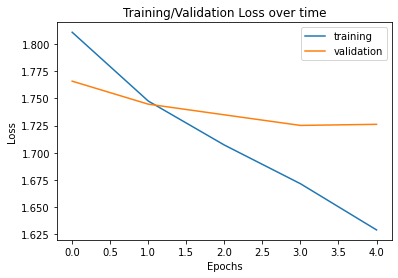

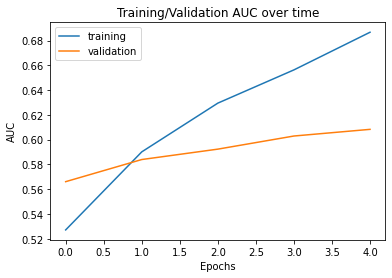

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss vs. epochs

print('Final AUC of training data set: ' + str(hist.history['auc'][-1]))
print('Final AUC of validation data set: ' + str(hist.history['val_auc'][-1]))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()

x='5'
p1, r1, p2, r2 = 'precision_'+x, 'recall_'+x, 'val_precision_'+x, 'val_recall_'+x

f1 = 2*hist.history[p1][-1]*hist.history[r1][-1] / (hist.history[p1][-1] + hist.history[r1][-1])
print('Training F1: ' + str(f1))
print()
f1 = 2*hist.history[p2][-1]*hist.history[r2][-1] / (hist.history[p2][-1] + hist.history[r2][-1])
print('Validation F1: ' + str(f1))
print()

#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model loss over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')

plt.show()

In [ ]:
x=newbin_i_val_comments

preds = model.predict(i_val_padded)
non_binarized = label_transformer.inverse_transform(preds)
print(non_binarized)

correct = [non_binarized[i] if non_binarized[i] == x[i] else -1 for i in range(len(non_binarized))]
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

print(len(preds))


2931
Using model as prediction
1584
1541


Binary outcome

Final accuracy of training data set: 0.646327793598175
Final accuracy of validation data set: 0.6577091217041016

Final loss of training data set: 0.6374735236167908
Final loss of validation data set: 0.6330196261405945

Final AUC of training data set: 0.6050336360931396
Final AUC of validation data set: 0.6150181889533997



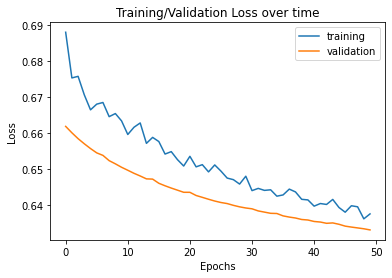

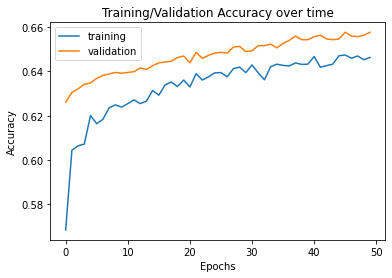

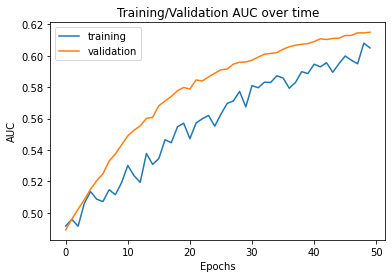

In [ ]:
import matplotlib.pyplot as plt


##Binary

# Plot the training and validation loss vs. epochs
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()
print('Final AUC of training data set: ' + str(hist.history['auc'][-1]))
print('Final AUC of validation data set: ' + str(hist.history['val_auc'][-1]))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plot_loss = plt.figure(3)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')

plt.show()

In [ ]:
#get accuracy if use mean as prediction
x=i_val_comments_2
preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))
 

950
950


In [ ]:
preds =model.predict(i_val_padded)
preds = np.round(preds)
correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

1958


In [ ]:
# model.summary()
# test_predictions = model.predict(i_val_padded)

# round_preds = np.round(test_predictions)
# num_correct_preds   = sum([1 if (binary_i_val_comments[i,:] == round_preds[i,:]).all() else 0 for i in range(len(round_preds))])
# print(num_correct_preds)

# print(num_correct_preds/len(round_preds))

#add to df 
df = pd.DataFrame({'label': list(binary_i_val_comments), 'pred': list(round_preds.astype(int))})
df.label = df.label.astype(str)
df.pred = df.pred.astype(str)
correct_preds = df[df.label == df.pred]
df.label.unique()

array(['[0 1 0 0 0 0 0 0 0 0]', '[1 0 0 0 0 0 0 0 0 0]',
       '[0 0 1 0 0 0 0 0 0 0]', '[0 0 0 0 0 0 0 0 0 1]',
       '[0 0 0 1 0 0 0 0 0 0]', '[0 0 0 0 0 1 0 0 0 0]',
       '[0 0 0 0 0 0 0 1 0 0]', '[0 0 0 0 1 0 0 0 0 0]',
       '[0 0 0 0 0 0 1 0 0 0]', '[0 0 0 0 0 0 0 0 1 0]'], dtype=object)

In [ ]:
import tensorflow.keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

epochs=40
vocab_size = 10000
embedding_dim = 100

t_train_comments_2 = np.array(t_train_comments_2)
t_val_comments_2 = np.array(t_val_comments_2)

# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), dtype='int32')

weight = t_reps_word2vec
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       weights=[weight.detach().numpy()], name='embedding')(input)
x = K.layers.Bidirectional(K.layers.LSTM(units = 128))(x)   #make bidirectional=True
# x = K.layers.LSTM(units = 128) (x)
x = K.layers.Dropout(rate=0.5)(x)

# x = K.layers.Dense(units=len(i_newbins), activation='softmax', 
#                    name='output_layer')(x)
x = K.layers.Dense(units=1, activation='sigmoid',  name='output_layer')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

opt = SGD(learning_rate=.001)

model.compile(optimizer=opt, 
              loss='binary_crossentropy', #use mean squared error
              metrics=['accuracy','AUC'
                       ])  #AUC, accuracy, loss

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=t_train_padded, 
         y = t_train_comments_2,
         batch_size=32,
         validation_data = (t_val_padded, t_val_comments_2),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

# model.save('gdrive/MyDrive/NLP_final_project/infertility_comments_classif_LSTM_001.pt')


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000000   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=t_val_comments_2

preds =model.predict(t_val_padded)
preds = np.round(preds)
correct = [preds[i] if preds[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

print(len(preds))


798
812
812
812
1481


In [ ]:
stats.mode(x)[0][0]

1

Final accuracy of training data set: 0.5432043075561523
Final accuracy of validation data set: 0.5482782125473022

Final loss of training data set: 0.6901344656944275
Final loss of validation data set: 0.6877641081809998

Final AUC of training data set: 0.5438740849494934
Final AUC of validation data set: 0.54105544090271



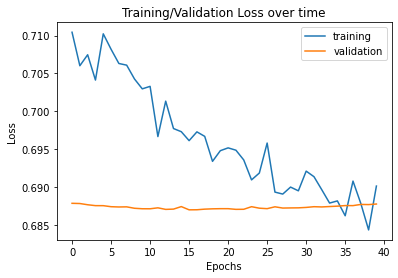

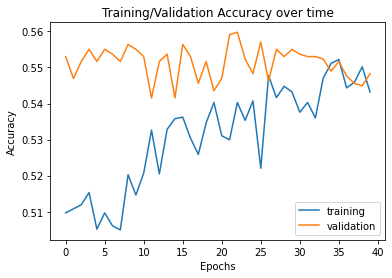

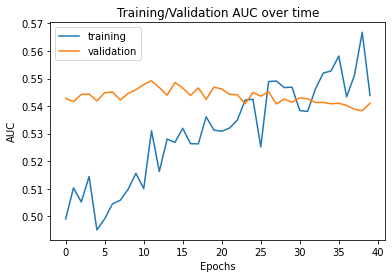

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss vs. epochs
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()
print('Final AUC of training data set: ' + str(hist.history['auc'][-1]))
print('Final AUC of validation data set: ' + str(hist.history['val_auc'][-1]))
print()
#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plot_loss = plt.figure(3)
plt.plot(range(epochs), hist.history['auc'], label = 'training')
plt.plot(range(epochs), hist.history['val_auc'], label = 'validation')
plt.title('Training/Validation AUC over time')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')

plt.show()

In [ ]:
import tensorflow.keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

epochs=5
vocab_size = 10000
embedding_dim = 100


# build embedding + LSTM model with functional API
input = K.Input(shape=(seq_len,), dtype='int32')

weight = t_reps_word2vec
x = K.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       weights=[weight.detach().numpy()], name='embedding')(input)
x = K.layers.Bidirectional(K.layers.LSTM(units = 128))(x)   #make bidirectional=True
# x = K.layers.LSTM(units = 128) (x)
x = K.layers.Dropout(rate=0.5)(x)


x = K.layers.Dense(units=len(t_newbins), activation='softmax',  name='output_layer')(x)
# x = K.layers.Dense(units=1, activation='sigmoid',  name='output_layer')(x)

model = K.Model(inputs=input, outputs=x)
model.summary()

opt = Adam(learning_rate=.01)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy', #use mean squared error
              metrics=['accuracy' #,'AUC'
                       ])  #AUC, accuracy, loss

#Evaluation
from keras.callbacks import History 
history = History() #save model metrics and loss per epoch


#train model
hist = model.fit(x=t_train_padded, 
         y = newbinary_t_train_comments,
         batch_size=32,
         validation_data = (t_val_padded, newbinary_t_val_comments),
         epochs=epochs,
         callbacks=[history] ,
         verbose=0
         ) #do not print log of every epoch

# model.save('gdrive/MyDrive/NLP_final_project/infertility_comments_classif_LSTM_001.pt')


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          1000000   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 6)                 1542      
Total params: 1,236,038
Trainable params: 1,236,038
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt


## Multiclass

# Plot the training and validation loss vs. epochs
print('Final accuracy of training data set: ' + str(hist.history['accuracy'][-1]))
print('Final accuracy of validation data set: ' + str(hist.history['val_accuracy'][-1]))
print()
print('Final loss of training data set: ' + str(hist.history['loss'][-1]))
print('Final loss of validation data set: ' + str(hist.history['val_loss'][-1]))
print()

#plot model loss over training and val
plot_loss = plt.figure(1)
plt.plot(range(epochs), hist.history['loss'], label = 'training')
plt.plot(range(epochs), hist.history['val_loss'], label = 'validation')
plt.title('Training/Validation Loss over time')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plot model accuracy over training and val
plot_loss = plt.figure(2)
plt.plot(range(epochs), hist.history['accuracy'], label = 'training')
plt.plot(range(epochs), hist.history['val_accuracy'], label = 'validation')
plt.title('Training/Validation Accuracy over time')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


plt.show()


NameError: ignored

In [ ]:

x=newbin_t_val_comments

preds = model.predict(t_val_padded)
non_binarized = label_transformer.inverse_transform(preds)
print(non_binarized)

correct = [non_binarized[i] if non_binarized[i] == x[i] else -1 for i in range(len(non_binarized))]
print(sum([1 if i != -1 else 0 for i in correct]))


#get accuracy if use mean as prediction

preds_mean = [np.round(np.mean(x))]*len(x)
correct = [preds_mean[i] if preds_mean[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use median as prediction
preds_median = [np.round(np.median(x))]*len(x)
correct = [preds_median[i] if preds_median[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

#get accuracy if use mode as prediction
import scipy.stats as stats
preds_mode = [stats.mode(x)[0][0]]*len(x)
correct = [preds_mode[i] if preds_mode[i] == x[i] else -1 for i in range(len(preds))]
print(sum([1 if i != -1 else 0 for i in correct]))

print(len(preds))


NameError: ignored